In [1]:
import json
data = sc.textFile('hdfs://master:54310/clean'). \
    map(lambda line: json.loads(line)). \
    map(lambda doc: {'Features': doc['Text'], 'Labels': doc['Hubs']})

In [2]:
from pyspark.mllib.feature import HashingTF
from pyspark.mllib.feature import IDF

In [3]:
documents = data.map(lambda x: x['Features'])

In [4]:
all_features = documents.flatMap(lambda doc: doc)
features_count = all_features.count()

In [5]:
hashingTF = HashingTF()
tf = hashingTF.transform(documents)

In [6]:
#tf.cache()
idf = IDF(minDocFreq=2).fit(tf)
tfidf = idf.transform(tf)

In [7]:
sv = tfidf.take(1)[0]

In [12]:
[(int(i),sv[int(i)]) for i in sv.indices]

[(3784, 4.1461641659503474),
 (7704, 7.0368233232067841),
 (22044, 7.1109708105234741),
 (26663, 5.3584320544487012),
 (28143, 5.4938700253438046),
 (28894, 4.7724989581959045),
 (38594, 17.473085896032362),
 (39384, 5.8099411010582722),
 (42454, 17.177184781242257),
 (56229, 2.3577122393836705),
 (61323, 4.2564919756879167),
 (66863, 1.9692510252822915),
 (84104, 3.0921652241287667),
 (91718, 1.9807876572220575),
 (96301, 4.1464910804735879),
 (102694, 2.6665112352763742),
 (104593, 8.8577921916490503),
 (111399, 14.436928798557767),
 (113264, 4.460567186426915),
 (115194, 3.7936428936834825),
 (129195, 3.8459885792636892),
 (132758, 2.9770357810303651),
 (140951, 4.0208028653100909),
 (151536, 5.090952689314439),
 (153869, 4.6974637722529904),
 (155266, 2.0599443839454512),
 (157237, 4.9463224036218678),
 (159406, 2.1482606702106462),
 (173879, 11.301136954499723),
 (175004, 3.6628164457735481),
 (177594, 3.4276355432034356),
 (187241, 6.3283496766805669),
 (191622, 1.994475125727741

In [26]:
key_tfidf = tfidf.flatMap(lambda sv: [(int(i),sv[int(i)]) for i in sv.indices]). \
        groupByKey()

In [19]:
import numpy as np

In [31]:
def process_group(group):
    tfidfs = np.array(list(group[1]));
    gmin = tfidfs.min()
    gmax = tfidfs.max()
    gave = tfidfs.mean()
    gnum = tfidfs.size
    return (group[0], (gmin, gave, gmax, gnum))

In [32]:
t = process_group(key_tfidf.take(1)[0])

In [33]:
t

(655360, (7.6610171474427462, 8.8296468817984177, 38.30508573721373, 59))

In [34]:
processed = key_tfidf.map(lambda group: process_group(group))

In [35]:
processed.take(1)

[(655360, (7.6610171474427462, 8.8296468817984177, 38.30508573721373, 59))]

In [64]:
small = processed.filter(lambda item: item[1][3]< 6)

In [65]:
processed = processed.cache()

In [68]:
lth5 = small.map(lambda item: item[1][2]*item[1][3]).sum() / small.map(lambda item: item[1][3]).sum()
lth10 = processed.filter(lambda item: 5<item[1][3]< 11). \
    map(lambda item: item[1][2]*item[1][3]).sum() / processed.filter(lambda item: 5<item[1][3]< 11).map(lambda item: item[1][3]).sum()
lth15 = processed.filter(lambda item: 10<item[1][3]< 16). \
    map(lambda item: item[1][2]*item[1][3]).sum() / processed.filter(lambda item: 10<item[1][3]< 16).map(lambda item: item[1][3]).sum()
lth100 = processed.filter(lambda item: 15<item[1][3]< 101). \
    map(lambda item: item[1][2]*item[1][3]).sum() / processed.filter(lambda item: 15<item[1][3]< 101).map(lambda item: item[1][3]).sum()

In [69]:
print(lth5, lth10, lth15, lth100)

20.8431298716 44.6547407928 52.5566486976 73.09539358


In [40]:
import seaborn; seaborn.set()
from matplotlib import pyplot as plt
%matplotlib inline

In [41]:
counts = processed.map(lambda item: item[1][3]).collect()

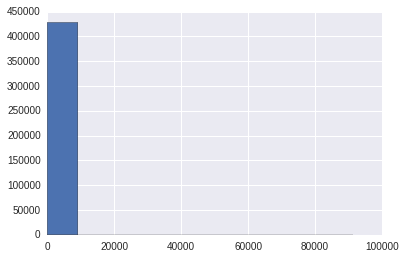

In [53]:
plt.hist(counts, bins=10)
plt.show()

In [58]:
sc.parallelize(counts).filter(lambda c: c<5).count()

323901